In [ ]:
! pip install phik
! pip install missingno

# Imports

In [44]:
# Simple import

from sklearn.datasets import make_classification # Make a pseudorandom datasets
import pandas as pd # You know what is it
import numpy as np
import seaborn as sns # Make a beautiful graphs 
import matplotlib.pyplot as plt # Make a graphs
import plotly.express as px # Make a complex graphs
from statsmodels.stats.outliers_influence import variance_inflation_factor # See https://en.wikipedia.org/wiki/Variance_inflation_factor
import phik
import missingno
import gc

# Complex import

from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    accuracy_score,
)

from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler
)

In [45]:
import warnings
warnings.filterwarnings("ignore")

In [46]:
# Samples
# features, target = make_classification(n_features=10)
# features = pd.DataFrame(features)
# target = pd.DataFrame(target, columns=['target'])
# train = pd.concat([features, target], axis=1)

# Do CLASS for your configuration and constants

In [47]:
class CFG:
    TARGET = 'Price'
    N_FOLDS = 5
    RANDOM_STATE = 52

    # Make your own directory with Data
    TRAIN_PATH = './Data/train.csv'
    TEST_PATH = './Data/test.csv'
    SUBMIT_PATH = './Data/sample_submission.csv'
    ORIGINAL_PATH = './Data/credit_risk_dataset.csv'

In [102]:
train = pd.read_csv(CFG.TRAIN_PATH, index_col='id')

# Prepare you own CLASS for data visualization and analysis  

In [103]:
class DataAnalysis:

    @staticmethod
    def info_df(df: pd.DataFrame) -> None:
        print('------------------------------')
        print('| Dataset information |')
        print('------------------------------')
        df.info()
        print('-----------------------------------------')
        print('| First 5 rows |')
        print('-----------------------------------------')
        display(df.head())
        print('--------------------')
        print('| Sum of duplicates |')
        print('--------------------')
        print(df.duplicated().sum())


    @staticmethod
    def view_distribution(data: pd.DataFrame, object_col = False, numeric_col = False) -> None:
        numeric_cols = data.select_dtypes(exclude=['object', 'datetime']).columns.to_list()
        object_cols = data.select_dtypes(include=['object']).columns.to_list()
        
        if numeric_col:
            fig, axes = plt.subplots(nrows=len(data[numeric_cols].columns), ncols=2, figsize=(len(numeric_cols)+15,len(numeric_cols)+7))
            j = 0
            for i in data[numeric_cols].columns:
                sns.histplot(data[numeric_cols][i], ax=axes[j, 0], kde=True, bins=40, edgecolor='black')
                axes[j, 0].set_title(i, fontsize=14)
                axes[j, 0].set_xlabel('')

                sns.boxplot(x=data[numeric_cols][i], ax=axes[j, 1], orient='h', palette='pink')
                axes[j, 1].set_title(i, fontsize=14)
                axes[j, 1].set_xlabel('')
                j += 1
            plt.suptitle(f'Num features\n\n', ha='center', fontweight='bold', fontsize=20);
            plt.tight_layout();
            plt.show();

        if object_col:
            _,ax = plt.subplots(len(object_cols),1, figsize=(len(object_cols)+7,len(object_cols)+20));
            ax =ax.flatten();
            g = 0
            for k in data[object_cols].columns:
                sns.countplot(data=data, x=k,ax=ax[g]);
                ax[g].set_xticklabels(labels=ax[g].get_xticklabels());
                ax[g].set_title(k);
                ax[g].set_xlabel('');
                g += 1
            plt.suptitle(f'Categorical\n\n', ha='center', fontweight='bold', fontsize=20);
            plt.show();


    @staticmethod
    def bloating_of_variance(data: pd.DataFrame) -> None:
        num = data.select_dtypes(exclude=['object', 'datetime']).columns.to_list()
        vif_data = pd.DataFrame()
        vif_data['feature'] = data.select_dtypes(exclude=['object', 'datetime']).columns.to_list()

        vif_data['VIF'] = [variance_inflation_factor(data[num].values, i) \
                                for i in range(len(data[num].columns))]
        print(vif_data)
    
    @staticmethod
    def balance_of_target(data: pd.DataFrame, target: str) -> None:
        sns.countplot(y=target, data=data, color='green', width=0.6);

    @staticmethod
    def plot_count(df: pd.core.frame.DataFrame, col: str, title_name: str='Train') -> None:
        # Set background color
        f, ax = plt.subplots(1, 2, figsize=(16, 7))
        plt.subplots_adjust(wspace=0.2)

        s1 = df[col].value_counts()
        N = len(s1)

        outer_sizes = s1
        inner_sizes = s1/N

        colors = sns.color_palette("mako")
        # hex_colors = [matplotlib.colors.to_hex(color) for color in colors]
        # print(hex_colors)
        
        outer_colors = ['#2e1e3b', '#413d7b', '#37659e', '#348fa7', '#40b7ad', '#8bdab2']
        inner_colors = ['#2e1e3b', '#413d7b', '#37659e', '#348fa7', '#40b7ad', '#8bdab2']
        #inner_colors = ['#59b3a3',] #'#433C64']

        ax[0].pie(
            outer_sizes,colors=outer_colors, 
            labels=s1.index.tolist(), 
            startangle=90, frame=True, radius=1.3, 
            explode=([0.05]*(N-1) + [.3]),
            wedgeprops={'linewidth' : 1, 'edgecolor' : 'black'}, 
            textprops={'fontsize': 12, 'weight': 'bold', 'color': 'white'}
        )

        textprops = {
            'size': 13, 
            'weight': 'bold', 
            'color': 'white'
        }

        ax[0].pie(
            inner_sizes, colors=inner_colors,
            radius=1, startangle=90,
            autopct='%1.f%%', explode=([.1]*(N-1) + [.3]),
            pctdistance=0.8, textprops=textprops
        )

        center_circle = plt.Circle((0,0), .68, color='black', fc='#243139', linewidth=0)
        ax[0].add_artist(center_circle)

        x = s1
        y = s1.index.tolist()
        sns.barplot(
            x=x, y=y, ax=ax[1],
            palette=colors, orient='horizontal'
        )

        ax[1].spines['top'].set_visible(False)
        ax[1].spines['right'].set_visible(False)
        ax[1].tick_params(
            axis='x',         
            which='both',      
            bottom=False,       
            labelbottom=False
        )

        for i, v in enumerate(s1):
            ax[1].text(v, i+0.1, str(v), color='white', fontweight='bold', fontsize=12)

        plt.setp(ax[1].get_yticklabels(), fontweight="bold")
        plt.setp(ax[1].get_xticklabels(), fontweight="bold")
        ax[1].set_xlabel(col, fontweight="bold", color='white')
        ax[1].set_ylabel('count', fontweight="bold", color='white')

        f.suptitle(f'{title_name}', fontsize=14, fontweight='bold', color='white')
        plt.tight_layout() 
        plt.show()
    
    @staticmethod
    def summary(data: pd.DataFrame) -> None:
        data = data.select_dtypes(exclude=['object', 'datetime'])
        sum = pd.DataFrame(data.dtypes, columns=['dtypes'])
        sum['missing#'] = data.isna().sum()
        sum['missing%'] = (data.isna().sum())/len(data)
        sum['uniques'] = data.nunique().values
        sum['count'] = data.count().values
        sum['skew'] = data.skew().values
        return sum
    
    @staticmethod
    def correlations(data: pd.DataFrame) -> None:
        data = data.drop(columns=CFG.TARGET)
        plt.figure(figsize=(15, 13));
        # Generate a mask for the upper triangle
        mask_pir = np.triu(np.ones_like(data.corr(method='pearson'), dtype=bool));
        mask_spi = np.triu(np.ones_like(data.corr(method='spearman'), dtype=bool));
       
        # Set up the matplotlib figure
        f, ax = plt.subplots(figsize=(11, 9));

        # Generate a custom diverging colormap
        cmap = sns.diverging_palette(230, 20, as_cmap=True);
        plt.title('PIRSON')
        sns.heatmap(data.corr(method='pearson'), annot=True, mask=mask_pir, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, robust=True);
        plt.show();
        
        plt.figure(figsize=(15, 13));
        f, ax = plt.subplots(figsize=(11, 9));
        plt.title('SPEARMAN')
        sns.heatmap(data.corr(method='spearman'), annot=True, mask=mask_spi, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, robust=True)
        plt.show();

        plt.figure(figsize=(15, 13));
        f, ax = plt.subplots(figsize=(11, 9));
        
        interval_cols = data.select_dtypes(exclude='object').columns.to_list()
        phik_overview = data.phik_matrix(interval_cols=interval_cols)
        plt.title(r'$\phi_K$')
        corr = phik_overview.round(2)
        mask = np.triu(np.ones_like(corr, dtype=bool))
        sns.heatmap(corr, mask=mask, cmap='pink_r', vmax=.3, center=0,
                annot=True, fmt='.2f', square=True, linewidths=.5, cbar_kws={"shrink": .5})

        significance_overview  = data.significance_matrix(interval_cols=interval_cols)

        plt.figure(figsize=(15, 13));
        plt.title('Statistical significance')
        corr = significance_overview.round(2)
        mask = np.triu(np.ones_like(corr, dtype=bool))
        sns.heatmap(corr, mask=mask, cmap='pink_r', vmax=5, vmin=-5, center=0,
                annot=True, fmt='.2f', square=True, linewidths=.5, cbar_kws={"shrink": .5})

        plt.show()
    
    @staticmethod
    def blinks(data: pd.DataFrame) -> None:
        print('Data gaps')
        missingno.matrix(data)

------------------------------
| Dataset information |
------------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 300000 entries, 0 to 299999
Data columns (total 10 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Brand                 290295 non-null  object 
 1   Material              291653 non-null  object 
 2   Size                  293405 non-null  object 
 3   Compartments          300000 non-null  float64
 4   Laptop Compartment    292556 non-null  object 
 5   Waterproof            292950 non-null  object 
 6   Style                 292030 non-null  object 
 7   Color                 290050 non-null  object 
 8   Weight Capacity (kg)  299862 non-null  float64
 9   Price                 300000 non-null  float64
dtypes: float64(3), object(7)
memory usage: 25.2+ MB
-----------------------------------------
| First 5 rows |
-----------------------------------------


,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price
id,,,,,,,,,,
0,Jansport,Leather,Medium,7.0,Yes,No,Tote,Black,11.611723,112.15875
1,Jansport,Canvas,Small,10.0,Yes,Yes,Messenger,Green,27.078537,68.88056
2,Under Armour,Leather,Small,2.0,Yes,No,Messenger,Red,16.643760,39.17320
3,Nike,Nylon,Small,8.0,Yes,No,Messenger,Green,12.937220,80.60793
4,Adidas,Canvas,Medium,1.0,Yes,Yes,Messenger,Green,17.749338,86.02312


--------------------
| Sum of duplicates |
--------------------
0
Data gaps


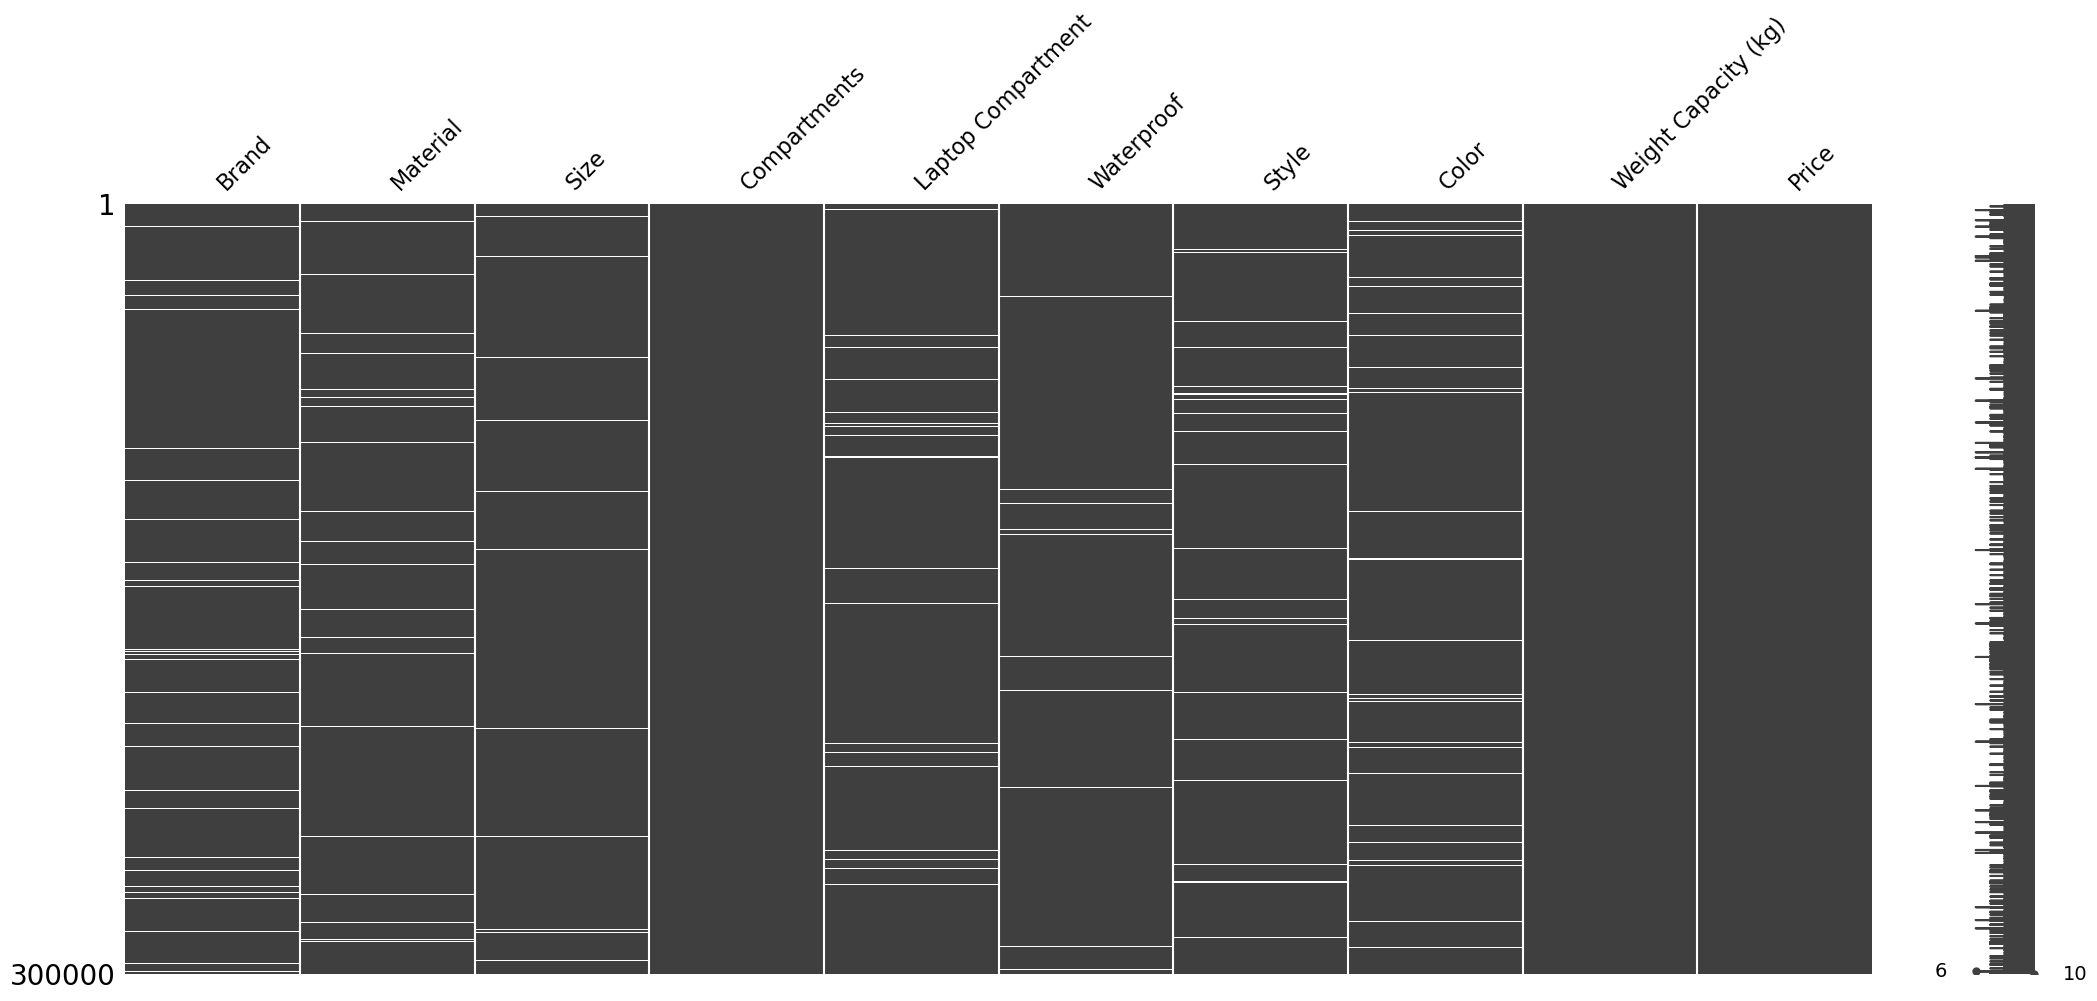

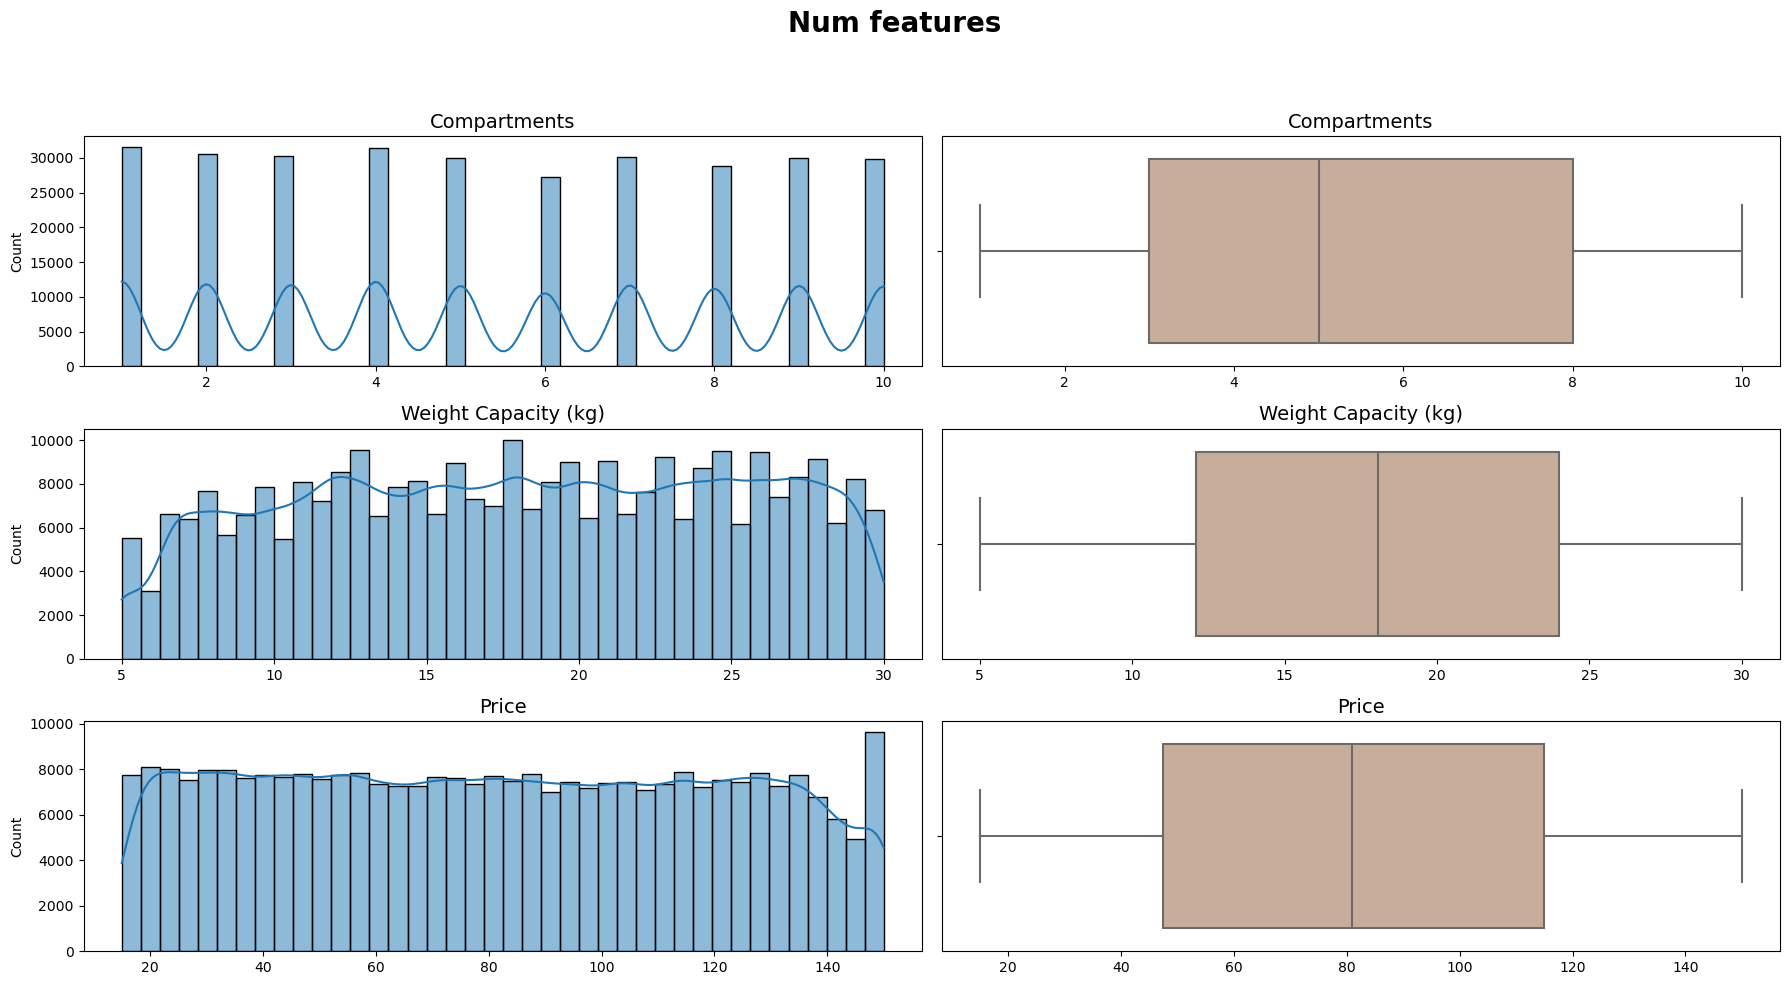

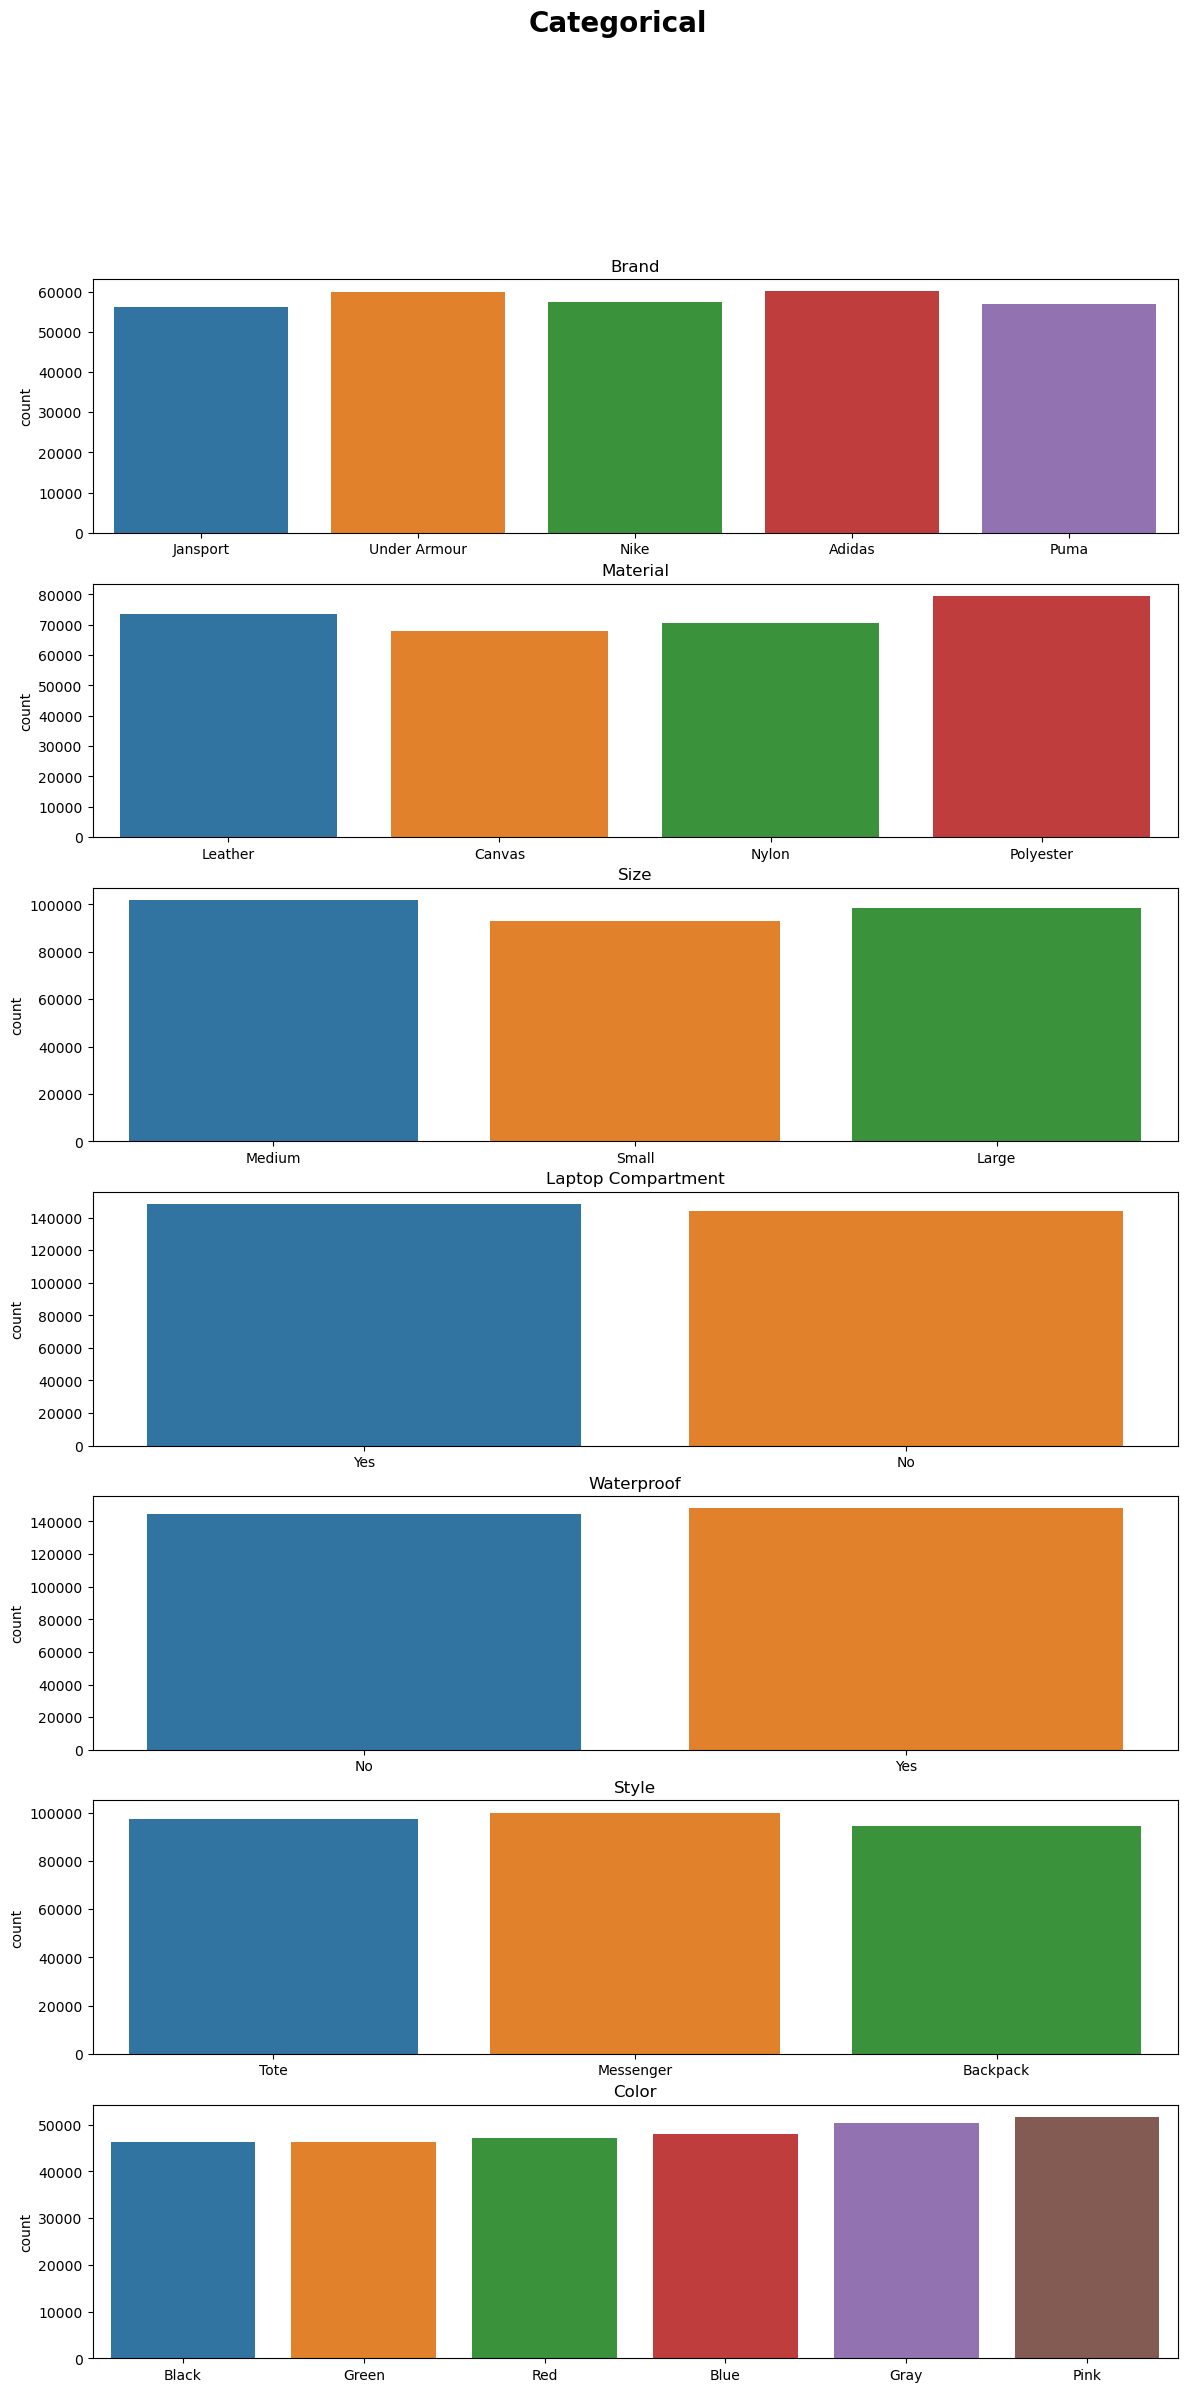

<Figure size 1500x1300 with 0 Axes>

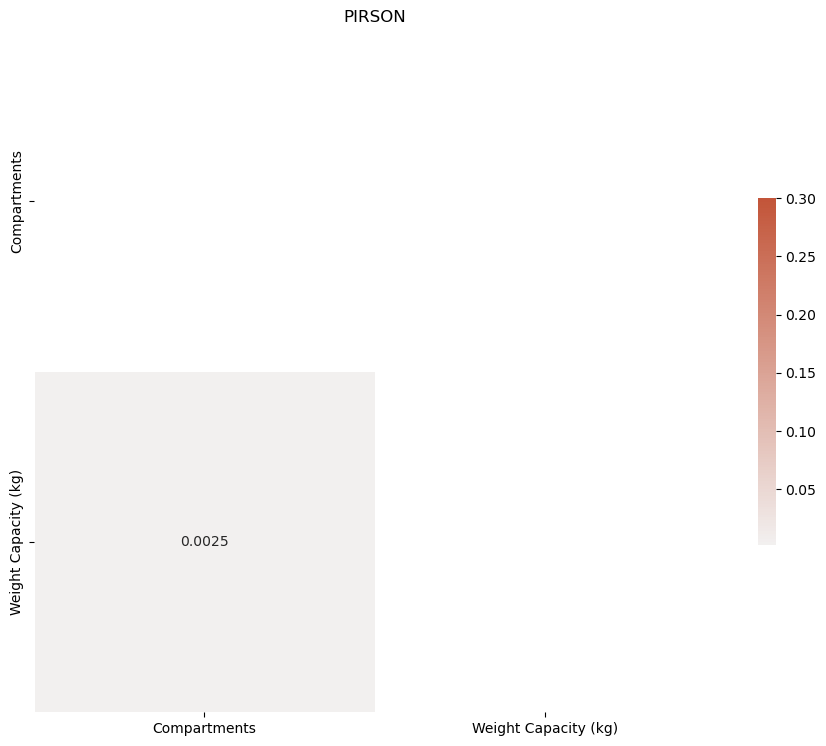

<Figure size 1500x1300 with 0 Axes>

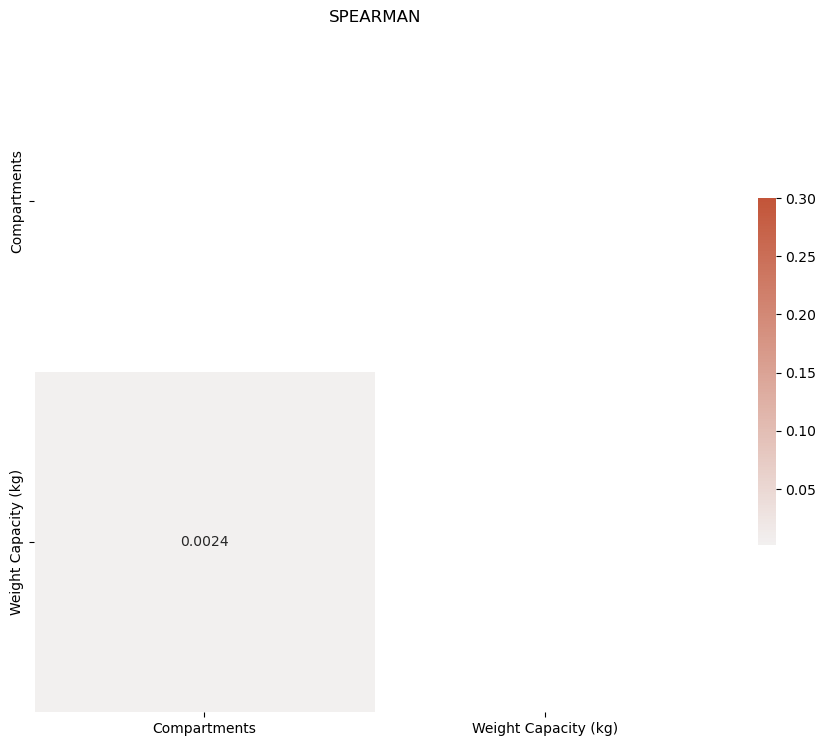

<Figure size 1500x1300 with 0 Axes>

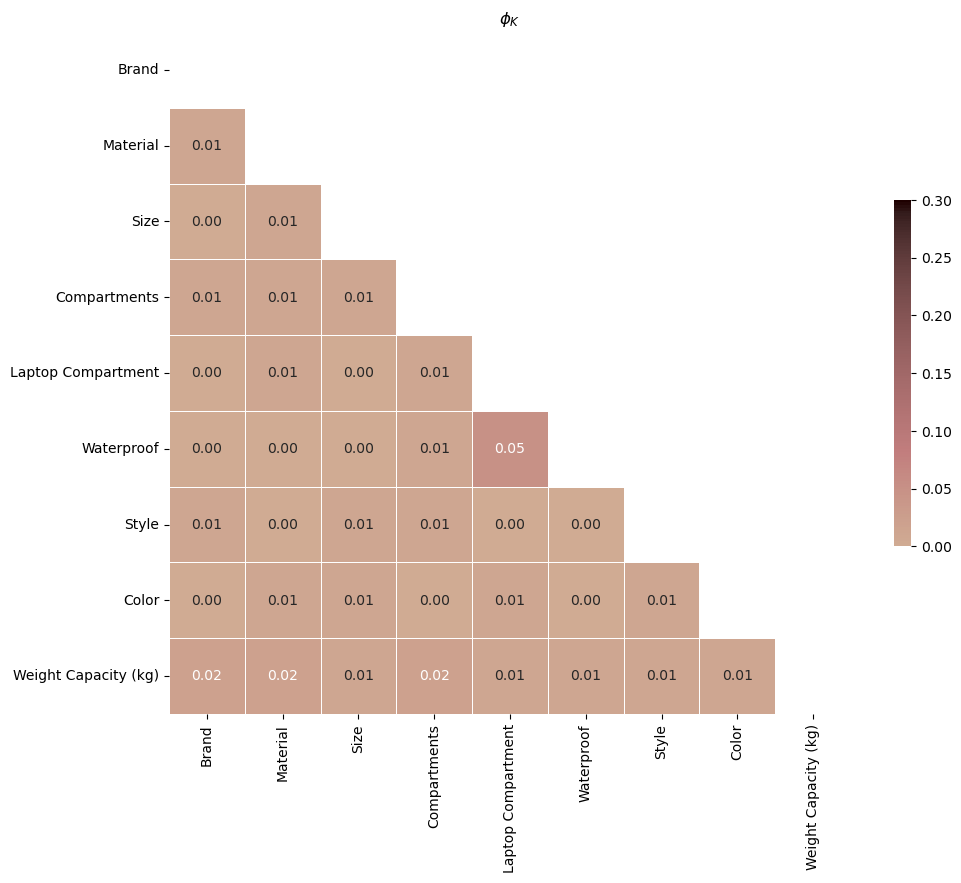

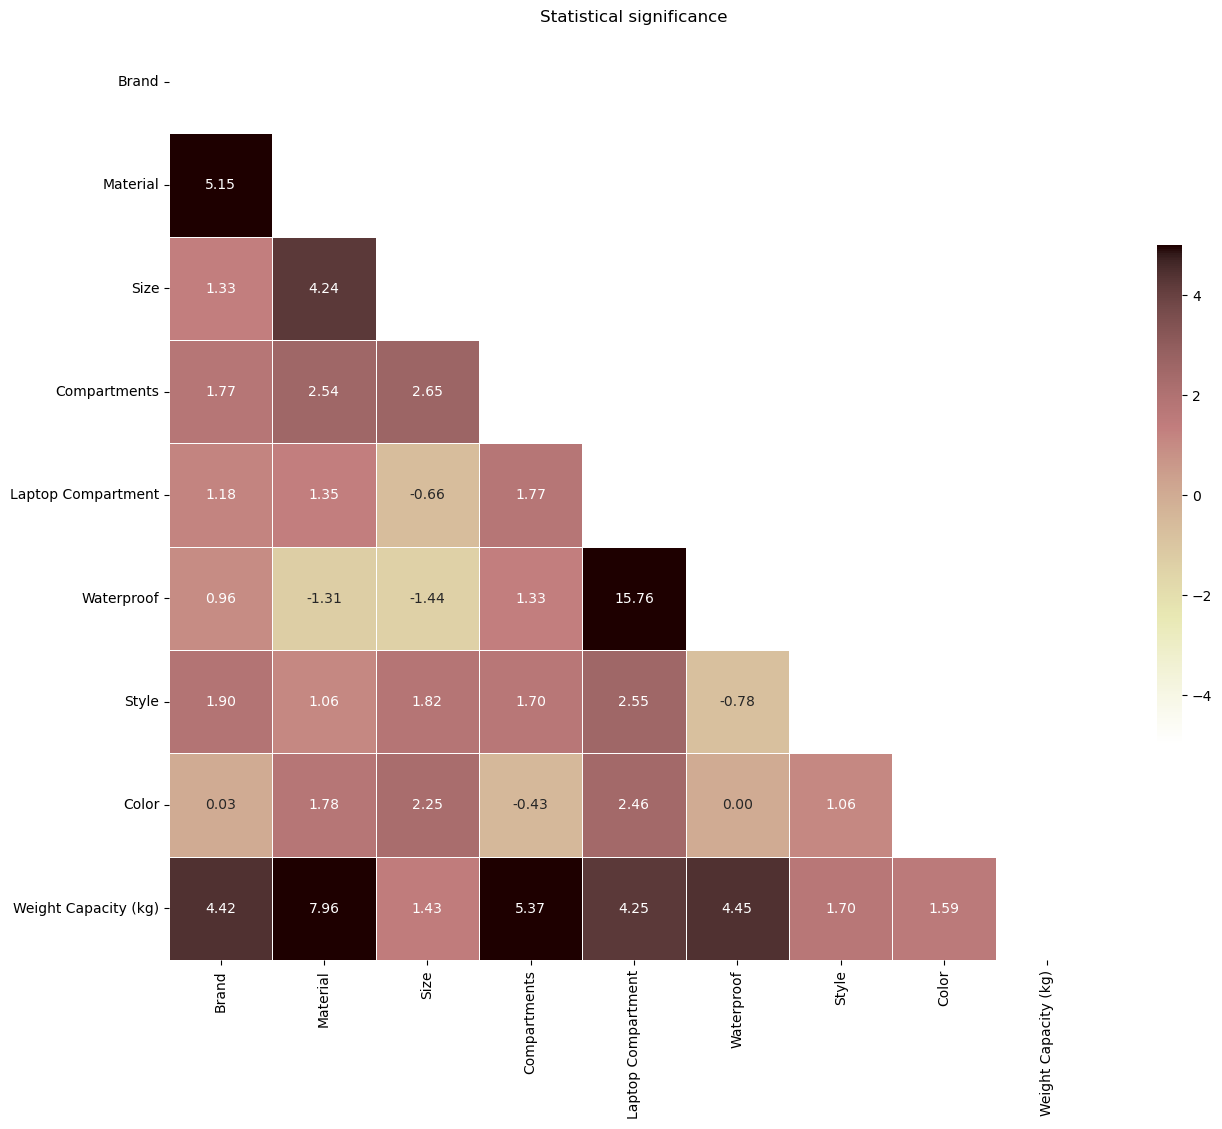

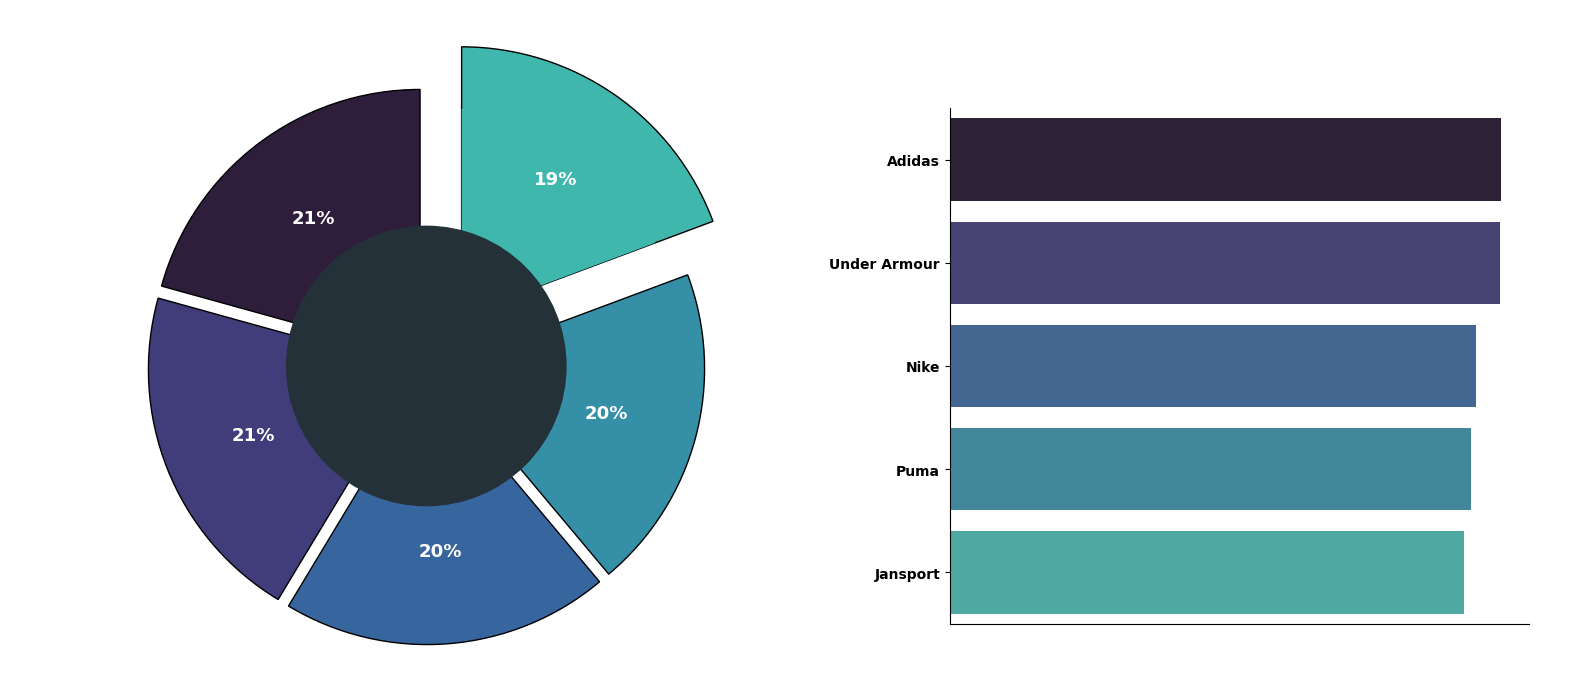

In [104]:
for data in [train]: # You should add dataframes
    DataAnalysis.info_df(data)
    DataAnalysis.blinks(data)
    DataAnalysis.view_distribution(data, numeric_col=True, object_col=True)
    DataAnalysis.correlations(data)
    # DataAnalysis.bloating_of_variance(data) # IF YOUR DATA HAS NOT GAPS
    # DataAnalysis.balance_of_target(data=data, target=CFG.TARGET) # FOR CLASSIFICATION
    DataAnalysis.plot_count(data, col='Brand', title_name='Brand Distribution of Train Data')

In [105]:
DataAnalysis.summary(train).style.background_gradient(cmap='Blues')

,dtypes,missing#,missing%,uniques,count,skew
Compartments,float64,0,0.000000,10,300000,0.029125
Weight Capacity (kg),float64,138,0.000460,181596,299862,-0.064239
Price,float64,0,0.000000,48212,300000,0.036883


In [106]:
train.describe().T\
            .style.bar(subset=['mean'], color=px.colors.qualitative.G10[2])\
            .background_gradient(subset=['std'], cmap='Blues')\
            .background_gradient(subset=['50%'], cmap='BuGn')

,count,mean,std,min,25%,50%,75%,max
Compartments,300000.000000,5.443590,2.890766,1.000000,3.000000,5.000000,8.000000,10.000000
Weight Capacity (kg),299862.000000,18.029994,6.966914,5.000000,12.097867,18.068614,24.002375,30.000000
Price,300000.000000,81.411107,39.039340,15.000000,47.384620,80.956120,115.018160,150.000000


In [107]:
# Shows gaps
pd.DataFrame(round(data.isna().mean()*100,1)).style.background_gradient('coolwarm')

,0
Brand,3.200000
Material,2.800000
Size,2.200000
Compartments,0.000000
Laptop Compartment,2.500000
Waterproof,2.400000
Style,2.700000
Color,3.300000
Weight Capacity (kg),0.000000
Price,0.000000


# SWEETVIZ

This is a powerful lib for "firstlook" analysis

In [11]:
!pip install sweetviz

In [109]:
import sweetviz as sv

my_report = sv.analyze(train, target_feat=CFG.TARGET)
my_report.show_html('Report.html')

                                             |          | [  0%]   00:00 -> (? left)

Report Report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


# Do math (LaTeX)

https://www.overleaf.com


\begin{equation}\begin{split}
profit=\sum^n_{i=1}classR_i \cdot (1 + seasonC_i)  \cdot nights_i\\ 
+ \frac {nights_i}{2} \cdot cleanR_i
\end{split}
\end{equation}


# Optimize your data

In [101]:
class DataLoader:
    def __init__(self, train: pd.DataFrame, test: pd.DataFrame):
        self.train = train
        self.test = test

    @staticmethod
    def ohe_encode_categorical_features(features: pd.DataFrame) -> pd.DataFrame:  
        print('--- Encoding categorical features')
        cat_features = features.select_dtypes(include=['object','category']).columns.to_list()
        
        encoder_ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)

        encoder_ohe.fit(features[cat_features])

        features[
            encoder_ohe.get_feature_names_out()
        ] = encoder_ohe.transform(features[cat_features])
        
        return features.drop(cat_features, axis=1)
    
    
    @staticmethod
    def reduce_mem_usage(dataframe):
        
        print('--- Reducing memory usage')
        initial_mem_usage = dataframe.memory_usage().sum() / 1024**2
        
        for col in dataframe.columns:
            col_type = dataframe[col].dtype

            if col_type.name in ['category', 'object']:
                raise ValueError(f"Column '{col}' is of type '{col_type.name}'")

            c_min = dataframe[col].min()
            c_max = dataframe[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    dataframe[col] = dataframe[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    dataframe[col] = dataframe[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    dataframe[col] = dataframe[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    dataframe[col] = dataframe[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    dataframe[col] = dataframe[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    dataframe[col] = dataframe[col].astype(np.float32)
                else:
                    dataframe[col] = dataframe[col].astype(np.float64)

        final_mem_usage = dataframe.memory_usage().sum() / 1024**2
        print('------ Memory usage before: {:.2f} MB'.format(initial_mem_usage))
        print('------ Memory usage after: {:.2f} MB'.format(final_mem_usage))
        print('------ Decreased memory usage by {:.1f}%'.format(100 * (initial_mem_usage - final_mem_usage) / initial_mem_usage))

        return dataframe

    def load(self):
        print(f'Loading data')
        
        train = self.train
        test = self.test
        
        train['is_train'] = 1
        test['is_train'] = 0
        dataframe = pd.concat([train, test])
        del train, test
        gc.collect()
        dataframe = self.ohe_encode_categorical_features(dataframe)
        dataframe = self.reduce_mem_usage(dataframe)
        
        train = dataframe[dataframe['is_train'] == 1].drop(columns=['is_train'])
        test = dataframe[dataframe['is_train'] == 0].drop(columns=['is_train', CFG.TARGET])
        
        del dataframe
        gc.collect()
        
        train[CFG.TARGET] = train[CFG.TARGET].astype(np.int8)
        
        return train, test

In [108]:
train, test = DataLoader(pd.read_csv(CFG.TRAIN_PATH, index_col='id'),pd.read_csv(CFG.TEST_PATH, index_col='id')).load()

Loading data
--- Encoding categorical features
--- Reducing memory usage
------ Memory usage before: 114.44 MB
------ Memory usage after: 30.99 MB
------ Decreased memory usage by 72.9%
